# BERT's concept of word

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter

from utils.data_processing import *
from utils.statistic_tests import *
from utils.vizualization import *

os.environ['CUDA_VISIBLE_DEVICES'] = "1"
torch.cuda.is_available()

%load_ext autoreload
%autoreload 2

In [8]:
# Preprocessing 
data_df = retrieve_preprocessed_df("../data/en_TaskIndependentData.json",print_ignored=True)
data_df.head(10)

We drop 777 ProperNoun and MetaUsage rows out of 4645.
Number of dropped single-meaning-mwe rows: 3200
Only MWEs that are tokenized like row['mwe'].split() have been retrieved at this step.      Specifically, we kept MWEs split into 2 tokens, in the singular form, and no different form from the MWE string ('running' != 'run').      To see the ignored rows, set print_ignored=True.
21 rows dropped where MWE not found as sublist in sentence.
There are 1,941 remaining sentences in the dataset.


,id,mwe,literal_meaning,_1,_2,_3,0/1,fine_grained,prior,sentence,after,prior_tokens,sentence_tokens,after_tokens,tokenized_mwe,normalized_sentence_tokens
0,38,sacred cow,divine cow,above criticism,None,None,1,divine cow,"Like beef, pork is also forbidden in Hinduism.","However, unlike the sacred cow, the pig repres...",This is considered to be particularly impure a...,"[like, beef, ,, pork, is, also, forbidden, in,...","[however, ,, unlike, the, sacred, cow, ,, the,...","[this, is, considered, to, be, particularly, i...","[sacred, cow]","[however, ,, unlike, the, sacred, cow, ,, the,..."
1,38,sacred cow,divine cow,above criticism,None,None,0,above criticism,"Besides, the Rights group said the Minister of...",The Rights group said the ministry has continu...,HURIWA recalled that the Federal Government on...,"[besides, ,, the, rights, group, said, the, mi...","[the, rights, group, said, the, ministry, has,...","[hu, ##ri, ##wa, recalled, that, the, federal,...","[sacred, cow]","[the, rights, group, said, the, ministry, has,..."
2,38,sacred cow,divine cow,above criticism,None,None,0,above criticism,"But in the Macquarie judgment, Judge Sandy Str...",Barwick says historically there has been littl...,The Fair Work Act is clear that employers cann...,"[but, in, the, macquarie, judgment, ,, judge, ...","[bar, ##wick, says, historically, there, has, ...","[the, fair, work, act, is, clear, that, employ...","[sacred, cow]","[bar, wick, says, historically, there, has, be..."
3,38,sacred cow,divine cow,above criticism,None,None,0,above criticism,"The Commissioner of Police, CP Abutu Yaro, who...",The state police boss also directed the full e...,No stone would be left unturned because we are...,"[the, commissioner, of, police, ,, cp, abu, ##...","[the, state, police, boss, also, directed, the...","[no, stone, would, be, left, un, ##turn, ##ed,...","[sacred, cow]","[the, state, police, boss, also, directed, the..."
4,38,sacred cow,divine cow,above criticism,None,None,0,above criticism,The committee shall come up with findings and ...,There is no sacred cow under the law of probit...,"For a deterrent in future, the Chairman shall ...","[the, committee, shall, come, up, with, findin...","[there, is, no, sacred, cow, under, the, law, ...","[for, a, deter, ##rent, in, future, ,, the, ch...","[sacred, cow]","[there, is, no, sacred, cow, under, the, law, ..."
5,38,sacred cow,divine cow,above criticism,None,None,0,above criticism,The House has now resumed discussion on a moti...,"Taking floor of the House, Senator Mohsin Aziz...",He said he presented himself before National A...,"[the, house, has, now, resumed, discussion, on...","[taking, floor, of, the, house, ,, senator, mo...","[he, said, he, presented, himself, before, nat...","[sacred, cow]","[taking, floor, of, the, house, ,, senator, mo..."
6,38,sacred cow,divine cow,above criticism,None,None,0,above criticism,We will deal with perpetrators with the force ...,"Going further with seriousness, Ajimobi went o...",Anyone who is implicated in the endemic and se...,"[we, will, deal, with, perpetrators, with, the...","[going, further, with, seriousness, ,, aj, ##i...","[anyone, who, is, implicated, in, the, endemic...","[sacred, cow]","[going, further, with, seriousness, ,, aj, imo..."
7,38,sacred cow,divine cow,above criticism,None,None,0,above criticism,The end was that nobody should be denied healt...,By making a sacred cow of the latter we have b...,An anonymous nurse working in intensive care s...,"[the, end, was, that, nobody, should, be, deni...","[by, making, a, sacred, cow, of, the, latter, ...","[an, anonymous, nurse, working, in, intensive,...","[sacred, cow]","[by, making, a, sacred, cow, of, the, latter, ..."
8,38,sacred cow,divine cow,above criticism,None,None,0,above criticism,"Although, the motion against NAB was talked ou...","No one is sacred cow, no one is above accounta...",It’s true that when NAB summoned me I was in R...,"[although, ,, the, motion, against, na, ##b, w...","

### Encoding

In [9]:
# Concatenate sentences in each row to form a paragraph
paragraphs = [' '.join(row) for row in zip(data_df['prior'], data_df['sentence'], data_df['after'])]
print(f"Nb paragraphs: {len(paragraphs):,}")
all_sentences = [row for row in zip(data_df['prior'], data_df['sentence'], data_df['after'])]

batch_size = 32
layer_id = 12
num_batches = (len(paragraphs) + batch_size - 1) // batch_size

all_sentences_token_number = get_nb_tokens_per_sent(all_sentences, batch_size, num_batches)

Nb paragraphs: 647


In [10]:

sentence_embeddings = retrieve_sentence_embeddings(paragraphs, batch_size, num_batches, layer_id, all_sentences_token_number, normalize=True)
print(f"There are {len(sentence_embeddings):,} retrieved sentences embeddings.")

There are 1,941 retrieved sentences embeddings.


In [11]:
# Extract embeddings from sentence_embeddings list
prior_embeddings_list = [embedding.detach().cpu().numpy() for embedding in sentence_embeddings[::3]]
sentence_embeddings_list = [embedding.detach().cpu().numpy() for embedding in sentence_embeddings[1::3]]
after_embeddings_list = [embedding.detach().cpu().numpy() for embedding in sentence_embeddings[2::3]]

data_df['prior_embeddings'] = prior_embeddings_list
data_df['sentence_embeddings'] = sentence_embeddings_list
data_df['after_embeddings'] = after_embeddings_list

# Verif
embeds = 0
for col in ['prior_embeddings', 'sentence_embeddings', 'after_embeddings']:
        embeds += len([e for e in data_df[col]])

print(f"There are {embeds:,} embeddings added to the dataset")

data_df.head()

There are 1,941 embeddings added to the dataset


,id,mwe,literal_meaning,_1,_2,_3,0/1,fine_grained,prior,sentence,after,prior_tokens,sentence_tokens,after_tokens,tokenized_mwe,normalized_sentence_tokens,prior_embeddings,sentence_embeddings,after_embeddings
0,38,sacred cow,divine cow,above criticism,None,None,1,divine cow,"Like beef, pork is also forbidden in Hinduism.","However, unlike the sacred cow, the pig repres...",This is considered to be particularly impure a...,"[like, beef, ,, pork, is, also, forbidden, in,...","[however, ,, unlike, the, sacred, cow, ,, the,...","[this, is, considered, to, be, particularly, i...","[sacred, cow]","[however, ,, unlike, the, sacred, cow, ,, the,...","[[0.6759236, 0.66212153, -1.6618252, 0.9362991...","[[0.6098151, 1.7681766, -1.6465403, 0.56608117...","[[0.2151477, 1.0862566, -0.9995496, 0.06341909..."
1,38,sacred cow,divine cow,above criticism,None,None,0,above criticism,"Besides, the Rights group said the Minister of...",The Rights group said the ministry has continu...,HURIWA recalled that the Federal Government on...,"[besides, ,, the, rights, group, said, the, mi...","[the, rights, group, said, the, ministry, has,...","[hu, ##ri, ##wa, recalled, that, the, federal,...","[sacred, cow]","[the, rights, group, said, the, ministry, has,...","[[0.11877325, 0.6358696, -1.3997782, -0.685774...","[[-0.6216701, 0.37132195, -0.57877874, 2.17395...","[[-1.8552895, 0.27881882, -1.1055176, -1.25063..."
2,38,sacred cow,divine cow,above criticism,None,None,0,above criticism,"But in the Macquarie judgment, Judge Sandy Str...",Barwick says historically there has been littl...,The Fair Work Act is clear that employers cann...,"[but, in, the, macquarie, judgment, ,, judge, ...","[bar, ##wick, says, historically, there, has, ...","[the, fair, work, act, is, clear, that, employ...","[sacred, cow]","[bar, wick, says, historically, there, has, be...","[[0.58015037, 0.17587033, -0.48686215, 0.23170...","[[1.1088475, 0.399195, -0.36517867, -1.9730049...","[[0.10055828, 0.14887595, -1.773173, -0.270606..."
3,38,sacred cow,divine cow,above criticism,None,None,0,above criticism,"The Commissioner of Police, CP Abutu Yaro, who...",The state police boss also directed the full e...,No stone would be left unturned because we are...,"[the, commissioner, of, police, ,, cp, abu, ##...","[the, state, police, boss, also, directed, the...","[no, stone, would, be, left, un, ##turn, ##ed,...","[sacred, cow]","[the, state, police, boss, also, directed, the...","[[0.25613585, -0.58438337, -0.45076647, 1.4367...","[[-1.0791, -1.1994786, -1.0619253, 0.65595776,...","[[0.46114945, 0.039026584, 0.06291677, -1.1842..."
4,38,sacred cow,divine cow,above criticism,None,None,0,above criticism,The committee shall come up with findings and ...,There is no sacred cow under the law of probit...,"For a deterrent in future, the Chairman shall ...","[the, committee, shall, come, up, with, findin...","[there, is, no, sacred, cow, under, the, law, ...","[for, a, deter, ##rent, in, future, ,, the, ch...","[sacred, cow]","[there, is, no, sacred, cow, under, the, law, ...","[[-0.573358, -0.010329925, -1.551857, 0.148782...","[[-0.1553069, 0.08521174, -1.2443142, -0.01691...","[[-0.94938004, -0.14042632, -0.6745712, -0.782..."


### Extracting MWE embeddings

In [12]:
#----------------------------- Retrieve the pairs' MWE embeddings -----------------------------#
data_df = add_mwe_embeddings_to_df(data_df, print_ignored=True)
data_df.head()  

[MWE embedding extraction] There are 0 ignored examples.


,id,mwe,literal_meaning,_1,_2,_3,0/1,fine_grained,prior,sentence,...,sentence_tokens,after_tokens,tokenized_mwe,normalized_sentence_tokens,prior_embeddings,sentence_embeddings,after_embeddings,literal_embedding,idiomatic_embedding,mwe_start
0,38,sacred cow,divine cow,above criticism,None,None,1,divine cow,"Like beef, pork is also forbidden in Hinduism.","However, unlike the sacred cow, the pig repres...",...,"[however, ,, unlike, the, sacred, cow, ,, the,...","[this, is, considered, to, be, particularly, i...","[sacred, cow]","[however, ,, unlike, the, sacred, cow, ,, the,...","[[0.6759236, 0.66212153, -1.6618252, 0.9362991...","[[0.6098151, 1.7681766, -1.6465403, 0.56608117...","[[0.2151477, 1.0862566, -0.9995496, 0.06341909...","[[3.1561208, 2.585915, -1.3529907, -0.5324929,...",None,4
1,38,sacred cow,divine cow,above criticism,None,None,0,above criticism,"Besides, the Rights group said the Minister of...",The Rights group said the ministry has continu...,...,"[the, rights, group, said, the, ministry, has,...","[hu, ##ri, ##wa, recalled, that, the, federal,...","[sacred, cow]","[the, rights, group, said, the, ministry, has,...","[[0.11877325, 0.6358696, -1.3997782, -0.685774...","[[-0.6216701, 0.37132195, -0.57877874, 2.17395...","[[-1.8552895, 0.27881882, -1.1055176, -1.25063...",None,"[[1.1588181, 0.68787414, -0.084417835, 1.05973...",39
2,38,sacred cow,divine cow,above criticism,None,None,0,above criticism,"But in the Macquarie judgment, Judge Sandy Str...",Barwick says historically there has been littl...,...,"[bar, ##wick, says, historically, there, has, ...","[the, fair, work, act, is, clear, that, employ...","[sacred, cow]","[bar, wick, says, historically, there, has, be...","[[0.58015037, 0.17587033, -0.48686215, 0.23170...","[[1.1088475, 0.399195, -0.36517867, -1.9730049...","[[0.10055828, 0.14887595, -1.773173, -0.270606...",None,"[[1.5319101, 0.97418636, -1.1444006, -0.355224...",27
3,38,sacred cow,divine cow,above criticism,None,None,0,above criticism,"The Commissioner of Police, CP Abutu Yaro, who...",The state police boss also directed the full e...,...,"[the, state, police, boss, also, directed, the...","[no, stone, would, be, left, un, ##turn, ##ed,...","[sacred, cow]","[the, state, police, boss, also, directed, the...","[[0.25613585, -0.58438337, -0.45076647, 1.4367...","[[-1.0791, -1.1994786, -1.0619253, 0.65595776,...","[[0.46114945, 0.039026584, 0.06291677, -1.1842...",None,"[[0.9130452, 1.102292, -0.36332324, -1.0517534...",20
4,38,sacred cow,divine cow,above criticism,None,None,0,above criticism,The committee shall come up with findings and ...,There is no sacred cow under the law of probit...,...,"[there, is, no, sacred, cow, under, the, law, ...","[for, a, deter, ##rent, in, future, ,, the, ch...","[sacred, cow]","[there, is, no, sacred, cow, under, the, law, ...","[[-0.573358, -0.010329925, -1.551857, 0.148782...","[[-0.1553069, 0.08521174, -1.2443142, -0.01691...","[[-0.94938004, -0.14042632, -0.6745712, -0.782...",None,"[[0.54086715, 0.25346377, -1.1413598, 0.325188...",3


In [10]:
data_df[(data_df['literal_embedding'].isna()) & (data_df['idiomatic_embedding'].isna())]

,id,mwe,literal_meaning,_1,_2,_3,0/1,fine_grained,prior,sentence,...,prior_tokens,sentence_tokens,after_tokens,tokenized_mwe,prior_embeddings,sentence_embeddings,after_embeddings,literal_embedding,idiomatic_embedding,mwe_start
155,104,bad hat,terrible hat,trouble maker,None,None,1,terrible hat,"And Haman, whose bad points and pointed hat li...",Considering all the bad characters who populat...,...,"[and, ham, ##an, ,, whose, bad, points, and, p...","[considering, all, the, bad, characters, who, ...","[and, yet, ,, it, ', s, hard, to, find, a, ba,...","[bad, hat]","[[0.22861762, 0.026392598, -0.0655764, -0.4406...","[[-0.15893687, 2.905548, 0.070740424, -0.40030...","[[-0.48130652, 0.9400548, -0.30524796, 1.30487...",None,None,None


In [ ]:
# Check rows where there are no mwe embedding retrieved
rows_to_drop = data_df[(data_df['literal_embedding'].isna()) & (data_df['idiomatic_embedding'].isna())].index
data_df = data_df.drop(index=rows_to_drop)
data_df = data_df.reset_index(drop=True)


In [12]:
# Verif
data_df[(data_df['literal_embedding'].isna()) & (data_df['idiomatic_embedding'].isna())].shape[0] > 0

False

In [13]:
# TODO: why is grass root not dropped? 
test = data_df[data_df['mwe'] == 'grass root']
if test['literal_meaning'].unique() not in test['fine_grained'].unique():
    print("wtf")

wtf


### Comp/non_comp pair comparison

In [13]:
#----------------------------- Create literal/idiomatic pairs -----------------------------#
# Pairs are created based on the fine_grained meaning

selected_pairs, pair_info = create_literal_idiomatic_pairs(data_df, unique_occurrences=False)


print(f"{'Pair':<25}{'MWE':<25}{'Meanings':<40}")
print("---------------------------------------------------------")
for pair in selected_pairs[10:40]:
    literal_index, idiomatic_index = pair
    literal_mwe = data_df.loc[literal_index, 'mwe']
    literal_meaning = data_df.loc[literal_index, 'fine_grained']
    idiomatic_meaning = data_df.loc[idiomatic_index, 'fine_grained']
    print(f"{f'{literal_index}/{idiomatic_index}':<25}{literal_mwe:<25}{f'{literal_meaning} / {idiomatic_meaning}':<40}")

print(f"\nThere are {len(selected_pairs)} pairs.")

if len(selected_pairs) == len(set(selected_pairs)):
    print("All pairs are unique.")
else:
    print("Not all pairs are unique.")

Pair                     MWE                      Meanings                                
---------------------------------------------------------
487/482                  acid test                acidic test / conclusive test           
487/475                  acid test                acidic test / conclusive test           
487/479                  acid test                acidic test / conclusive test           
487/476                  acid test                acidic test / conclusive test           
487/483                  acid test                acidic test / conclusive test           
487/481                  acid test                acidic test / conclusive test           
487/480                  acid test                acidic test / conclusive test           
487/477                  acid test                acidic test / conclusive test           
488/478                  acid test                acidic test / conclusive test           
488/482                  acid te

In [14]:
pair_df = pd.DataFrame(pair_info)
pair_df.index.name = 'mwe'
pair_df.index = pair_df.index.map({0: 'literal', 1: 'idiomatic'})
pair_df = pair_df.T
pair_df.sort_index()

mwe,literal,idiomatic
acid test,7,9
ancient history,15,7
baby blues,17,3
bad hat,9,8
best man,10,10
big cheese,3,19
big fish,7,4
big wig,3,11
blue blood,4,13
brass ring,9,17


In [17]:
data_df[data_df['mwe'] == 'grass root']

,id,mwe,literal_meaning,_1,_2,_3,0/1,fine_grained,prior,sentence,...,prior_tokens,sentence_tokens,after_tokens,tokenized_mwe,prior_embeddings,sentence_embeddings,after_embeddings,literal_embedding,idiomatic_embedding,mwe_start
329,173,grass root,herb root,ordinary people,None,None,0,ordinary people,The Democrats having stolen the election are n...,Any deviation from their leftist agenda regard...,...,"[the, democrats, having, stolen, the, election...","[any, deviation, from, their, leftist, agenda,...","[this, new, normal, created, by, their, new, g...","[grass, root]","[[0.84305364, 0.47047624, 0.47801504, 0.799031...","[[-1.0788782, 0.46979156, 2.3893924, -0.128710...","[[0.5950292, 1.2804316, 0.7070488, 0.68297595,...",None,"[[0.67195725, 1.1352199, 0.9243462, 1.4955536,...",57
330,173,grass root,herb root,ordinary people,None,None,0,ordinary people,Appropriate care is being taken to make this i...,It is hoped that this implementation plan so f...,...,"[appropriate, care, is, being, taken, to, make...","[it, is, hoped, that, this, implementation, pl...","[the, major, portions, of, ne, ##p, will, be, ...","[grass, root]","[[0.34443155, -1.085416, 0.9440436, 0.01538550...","[[-0.030132292, -0.44082654, -0.9020488, 0.052...","[[-1.2528034, -1.2480112, 1.7230089, -0.914602...",None,"[[-0.8351457, -0.49610054, 1.3243668, -1.87860...",33
331,173,grass root,herb root,ordinary people,None,None,0,ordinary people,The art of fine batting can now be taught with...,We recognise the need for cricket to embrace t...,...,"[the, art, of, fine, batting, can, now, be, ta...","[we, recognise, the, need, for, cricket, to, e...","[delhi, bulls, is, proud, to, be, the, first, ...","[grass, root]","[[0.37901214, -1.4353969, -0.21842161, 0.88860...","[[0.9809395, -0.39470366, -0.22134931, -0.9543...","[[0.82169133, -1.6611302, -0.36748987, -1.9082...",None,"[[-0.036310144, -0.50814664, -0.00808118, -1.4...",33
332,173,grass root,herb root,ordinary people,None,None,0,ordinary people,A rejuvenated Mumbai Congress under the leader...,Sanjay Nirupam also took to social media to sh...,...,"[a, re, ##ju, ##ven, ##ated, mumbai, congress,...","[sanjay, ni, ##rup, ##am, also, took, to, soci...","[the, in, ##fighting, in, the, mumbai, congres...","[grass, root]","[[0.28973216, -1.445462, -0.8587233, 0.4285584...","[[0.66353583, -1.3366247, 0.28576604, -1.03472...","[[-1.6671708, -2.0214274, -2.7361352, -0.75455...",None,"[[0.8084007, -0.82046896, 1.6532339, -0.395019...",25
333,173,grass root,herb root,ordinary people,None,None,0,ordinary people,The events have been finalised in cities of Ut...,We will tell farmers at the grass root level t...,...,"[the, events, have, been, final, ##ised, in, c...","[we, will, tell, farmers, at, the, grass, root...","[he, added, that, the, roll, ##back, of, cases...","[grass, root]","[[0.007304321, -1.328787, -0.73374605, 0.44600...","[[1.2180194, -0.9934382, -0.83245116, 0.033746...","[[0.9755333, 0.021743339, -0.7276186, -0.35905...",None,"[[-0.2728543, -0.63627595, 0.30782184, -0.7645...",6
334,173,grass root,herb root,ordinary people,None,None,0,ordinary people,"VAM General Secretary, Jairos Nkhoma, was spea...",Nkhoma said those that will be elected should ...,...,"[va, ##m, general, secretary, ,, jai, ##ros, n...","[nk, ##hom, ##a, said, those, that, will, be, ...","[we, need, dedicated, leaders, who, can, up, #...","[grass, root]","[[-0.32654303, -0.92871296, -0.22747883, 0.996...","[[-1.3578727, 0.19417532, 0.84016716, -0.05573...","[[1.562294, -1.6786165, -0.17617074, 0.6962128...",None,"[[-0.47286665, -1.1697975, 0.4047644, -1.06425...",27
335,173,grass root,herb root,ordinary people,None,None,0,ordinary people,The process through which we undermine certain...,Past collapse tend to follow somewhat similar ...,...,"[the, process, through, which, we, undermine, ...","[past, collapse, tend, to, follow, somewhat, s...","[there, is, a, reason, why, corporate, takeove...","[grass, root]","[[1.8203654, -0.2762174, -0.5472

In [6]:
value_to_check = 323
for pair in selected_pairs:
    # Check if the value is present in either element of the pair
    if value_to_check in pair:
        print(f"The value {value_to_check} is present in the pair {pair}.")
        break
else:
    print(f"The value {value_to_check} is not present in any pair.")

The value 323 is present in the pair (328, 323).


In [15]:
#----------------------------- Computing the similarity scores -----------------------------#

results = get_sim_scores(selected_pairs, data_df) #, layer_id)
export_to_csv(results, '../results/pair_similarities.csv')
# Create a dfs to store the results
results_df = create_result_df(results, weighted=True)
results_df.to_csv('../results/pair_similarities_summary.csv', index=False)


# Compare weighted and unweighted averages
unweighted_df = create_result_df(results, weighted=False)
display(results_df, unweighted_df)


,Pair,Example,Cosine similarity
0,C_0 vs NC_0,big/big,0.297810
1,C_1 vs NC_1,fish/fish,0.302989
2,C_0 vs C_1,big_1/fish_1,0.707589
3,NC_0 vs NC_1,big_2/fish_2,0.697497


,Pair,Example,Cosine similarity
0,C_0 vs NC_0,big/big,0.300983
1,C_1 vs NC_1,fish/fish,0.301914
2,C_0 vs C_1,big_1/fish_1,0.708978
3,NC_0 vs NC_1,big_2/fish_2,0.692709


In [19]:
mwe_scores = {}
for mwe, scores in results['NC_0 vs NC_1'].items():
    mwe_scores[mwe] = np.mean(scores)
    
print(mwe_scores)


{'acid test': 0.70134145, 'chain reaction': 0.79615134, 'ancient history': 0.72818035, 'public service': 0.6686571, 'sitting duck': 0.6545214, 'cutting edge': 0.68086123, 'fine line': 0.67495066, 'sacred cow': 0.71897477, 'busy bee': 0.7677712, 'brass ring': 0.7545912, 'heavy cross': 0.71652865, 'silver spoon': 0.6440957, 'ground floor': 0.68277603, 'baby blues': 0.6040042, 'hard shoulder': 0.6813407, 'silver lining': 0.7866431, 'bad hat': 0.63758767, 'nest egg': 0.7846376, 'big cheese': 0.59403, 'dry land': 0.66068524, 'best man': 0.6676785, 'blue blood': 0.6539102, 'small fry': 0.6036148, 'rocket science': 0.68785304, 'poison pill': 0.71678406, 'double cross': 0.7433854, 'goose egg': 0.6819166, 'brick wall': 0.8317133, 'big wig': 0.60291386, 'smoke screen': 0.7564451, 'top dog': 0.6268304, 'gold mine': 0.7459806, 'food market': 0.5476522, 'glass ceiling': 0.76044005, 'low profile': 0.7387563, 'fish story': 0.64167446, 'rat run': 0.68389916, 'big fish': 0.622341, 'closed book': 0.7635

Non-Compositional Scores: Min=0.5477, Max=0.8317, Median=0.6828
Compositional Scores: Min=0.5689, Max=0.8583, Median=0.7089


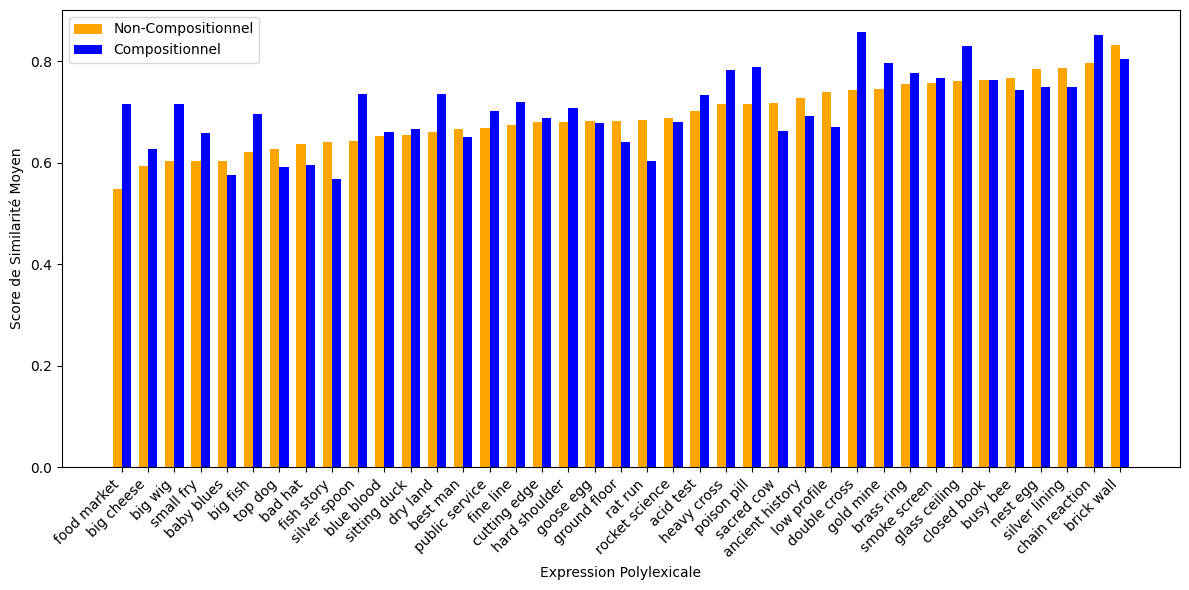

In [23]:
# Sort mwe_scores by values (average scores) in ascending order
sorted_mwe_scores = sorted(mwe_scores.items(), key=itemgetter(1))

# Create lists of MWE names and average scores from sorted dictionary
mwes = [mwe for mwe, score in sorted_mwe_scores]
noncomp_scores = [np.mean(results['NC_0 vs NC_1'][mwe]) for mwe in mwes]
comp_scores = [np.mean(results['C_0 vs C_1'][mwe]) for mwe in mwes]
print(f"Non-Compositional Scores: Min={np.min(noncomp_scores):.4f}, Max={np.max(noncomp_scores):.4f}, Median={np.median(noncomp_scores):.4f}")
print(f"Compositional Scores: Min={np.min(comp_scores):.4f}, Max={np.max(comp_scores):.4f}, Median={np.median(comp_scores):.4f}")

# Set up the x-axis positions for the bars
x = np.arange(len(mwes))
width = 0.35  # Width of the bars

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, noncomp_scores, width, label='Non-Compositionnel', color='orange')
plt.bar(x + width/2, comp_scores, width, label='Compositionnel', color='blue')
plt.xticks(x, mwes, rotation=45, ha='right')
plt.xlabel('Expression Polylexicale')
plt.ylabel('Score de Similarité Moyen')
# plt.title('Similarité Scores for MWEs')
plt.legend()
plt.tight_layout()
plt.savefig('../results/initial_tests.pdf')
plt.show()


First elements Scores: Min=0.1765, Max=0.4299, Median=0.3151
Second elements Scores: Min=0.1489, Max=0.4133, Median=0.3132


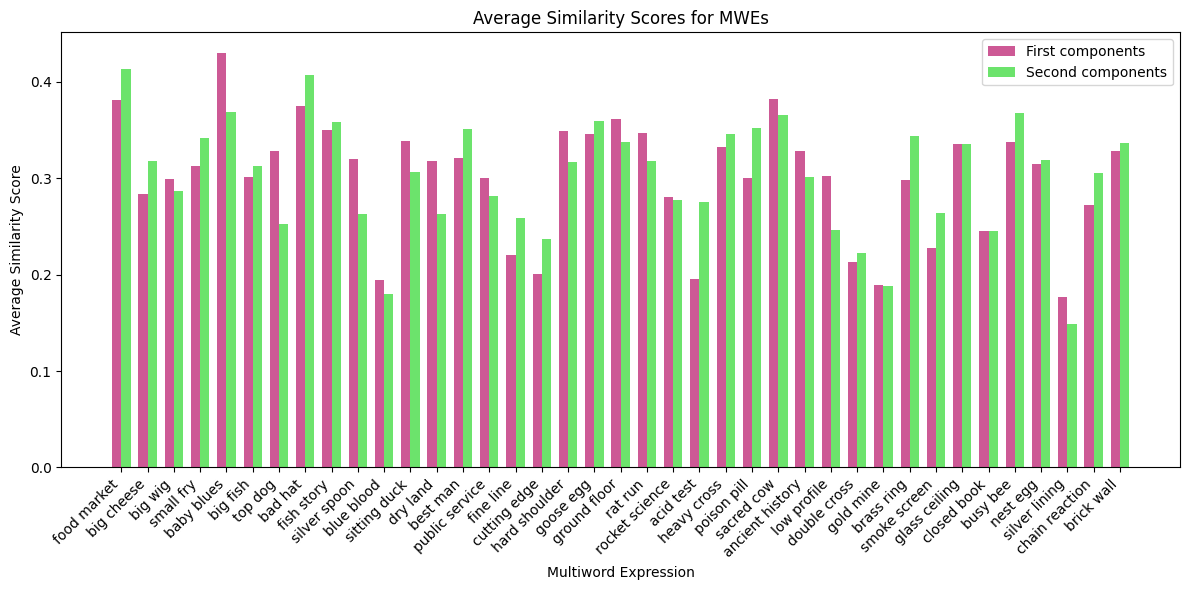

In [48]:
# Sort mwe_scores by values (average scores) in ascending order
sorted_mwe_scores = sorted(mwe_scores.items(), key=itemgetter(1))

# Create lists of MWE names and average scores from sorted dictionary
mwes = [mwe for mwe, score in sorted_mwe_scores]
first_elt = [np.mean(results['comp_0 vs noncomp_0'][mwe]) for mwe in mwes]
second_elt = [np.mean(results['comp_1 vs noncomp_1'][mwe]) for mwe in mwes]
print(f"First elements Scores: Min={np.min(first_elt):.4f}, Max={np.max(first_elt):.4f}, Median={np.median(first_elt):.4f}")
print(f"Second elements Scores: Min={np.min(second_elt):.4f}, Max={np.max(second_elt):.4f}, Median={np.median(second_elt):.4f}")

# Set up the x-axis positions for the bars
x = np.arange(len(mwes))
width = 0.35  # Width of the bars

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, first_elt, width, label='First components', color='#CD5995')  
plt.bar(x + width/2, second_elt, width, label='Second components', color='#6CE36C')  

plt.xticks(x, mwes, rotation=45, ha='right')
plt.xlabel('Multiword Expression')
plt.ylabel('Average Similarity Score')
plt.title('Average Similarity Scores for MWEs')
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
# With unique_occurrences=True when selecting the pairs

results = get_sim_scores(selected_pairs, data_df) #, layer_id)
results_df = create_result_df(results, weighted=True)
results_df.to_csv('../results/pair_similarities_summary.csv', index=False)


# Compare weighted and unweighted averages
unweighted_df = create_result_df(results, weighted=False)
display(results_df, unweighted_df)


,Pair,Example,Cosine similarity
0,comp_0 vs noncomp_0,big/big,0.297784
1,comp_1 vs noncomp_1,fish/fish,0.302974
2,comp_0 vs comp_1,big_1/fish_1,0.707586
3,noncomp_0 vs noncomp_1,big_2/fish_2,0.697485


,Pair,Example,Cosine similarity
0,comp_0 vs noncomp_0,big/big,0.300951
1,comp_1 vs noncomp_1,fish/fish,0.301899
2,comp_0 vs comp_1,big_1/fish_1,0.708968
3,noncomp_0 vs noncomp_1,big_2/fish_2,0.692700


### Single-sentence context

In [23]:
all_sentences = [row for row in data_df['sentence']]
print(f"There are {len(all_sentences)}")
all_sentences[:5]

There are 647


['However, unlike the sacred cow, the pig represents impurity and filth, because it eats our wasted food.',
 'The Rights group said the ministry has continued to carry on business of administering public funds with scant regard to the principles of transparency and accountability just as the Rights group said the minister seems to be a sacred cow who is above public scrutiny.',
 'Barwick says historically there has been little appetite for controversy on annual leave in Australia, likening the entitlement to an “industrial sacred cow”.',
 'The state police boss also directed the full enforcement of other traffic regulations, saying that nobody should be a sacred cow or untouchable in the process.',
 'There is no sacred cow under the law of probity and accountability.']

In [24]:
batch_size = 32
layer_id = 12
num_batches = (len(all_sentences) + batch_size - 1) // batch_size
print(f"There are {num_batches} batches.")

There are 21 batches.


In [25]:
# New version of get_nb_tokens_per_sent() due to the following line that was made to deal with tuples of 3 sentences (unconcatenated paragraphs), which is nolonger the case:
# all_sentences_tokenized = [[tokenized for row in batch for tokenized in [tokenizer.tokenize(sent) for sent in row]] for batch in all_sentences_batches]

all_sentences_batches = [all_sentences[i * batch_size:(i + 1) * batch_size] for i in range(num_batches)]
all_sentences_tokenized = [[tokenizer.tokenize(sent) for sent in batch] for batch in all_sentences_batches]
all_sentences_token_number = [[len(tokenized_sentence) for tokenized_sentence in batch] for batch in all_sentences_tokenized]
print(f"There are {len(all_sentences_token_number)} batches")
all_sentences_token_number[:2]

There are 21 batches


[[23,
  47,
  31,
  30,
  15,
  28,
  38,
  15,
  16,
  52,
  31,
  27,
  15,
  18,
  14,
  30,
  23,
  15,
  32,
  77,
  37,
  33,
  36,
  25,
  46,
  22,
  35,
  35,
  43,
  27,
  25,
  23],
 [26,
  25,
  28,
  36,
  37,
  39,
  23,
  26,
  39,
  41,
  20,
  17,
  34,
  34,
  9,
  54,
  61,
  19,
  27,
  18,
  19,
  30,
  11,
  13,
  12,
  12,
  27,
  77,
  46,
  37,
  46,
  26]]

In [26]:
sentence_embeddings = retrieve_sentence_embeddings(all_sentences, batch_size, num_batches, layer_id, all_sentences_token_number, normalize=True)
sentence_embeddings_list = [embedding.cpu().numpy() for embedding in sentence_embeddings]

In [27]:
data_df['no_context_sentence_embeddings'] = sentence_embeddings_list
data_df.head()

,id,mwe,literal_meaning,_1,_2,_3,0/1,fine_grained,prior,sentence,...,sentence_tokens,after_tokens,tokenized_mwe,prior_embeddings,sentence_embeddings,after_embeddings,literal_embedding,idiomatic_embedding,mwe_start,no_context_sentence_embeddings
0,38,sacred cow,divine cow,above criticism,None,None,1,divine cow,"Like beef, pork is also forbidden in Hinduism.","However, unlike the sacred cow, the pig repres...",...,"[however, ,, unlike, the, sacred, cow, ,, the,...","[this, is, considered, to, be, particularly, i...","[sacred, cow]","[[0.6744263, 0.6605894, -1.6621323, 0.9363171,...","[[0.60835195, 1.7660854, -1.6468436, 0.5660775...","[[0.21388817, 1.0845101, -0.9996871, 0.0633859...","[[3.153344, 2.5834105, -1.3532188, -0.53256094...",None,4,"[[0.83608407, -0.4274763, 0.05943046, 0.922178..."
1,38,sacred cow,divine cow,above criticism,None,None,0,above criticism,"Besides, the Rights group said the Minister of...",The Rights group said the ministry has continu...,...,"[the, rights, group, said, the, ministry, has,...","[hu, ##ri, ##wa, recalled, that, the, federal,...","[sacred, cow]","[[0.11756344, 0.6343508, -1.4000181, -0.685851...","[[-0.6224979, 0.36993676, -0.5788083, 2.174046...","[[-1.8554807, 0.2774804, -1.1056821, -1.250745...",None,"[[1.1570717, 0.686329, -0.08432065, 1.0597583,...",39,"[[0.59457415, -0.15478662, -2.7324042, 3.41688..."
2,38,sacred cow,divine cow,above criticism,None,None,0,above criticism,"But in the Macquarie judgment, Judge Sandy Str...",Barwick says historically there has been littl...,...,"[bar, ##wick, says, historically, there, has, ...","[the, fair, work, act, is, clear, that, employ...","[sacred, cow]","[[0.5787025, 0.17458396, -0.4868681, 0.2316777...","[[1.1071268, 0.39779574, -0.36515346, -1.97315...","[[0.099357866, 0.14760321, -1.7735085, -0.2706...",None,"[[1.5299711, 0.9724965, -1.1445751, -0.3552822...",27,"[[1.1170235, -0.2750211, -0.5321184, -0.292883..."
3,38,sacred cow,divine cow,above criticism,None,None,0,above criticism,"The Commissioner of Police, CP Abutu Yaro, who...",The state police boss also directed the full e...,...,"[the, state, police, boss, also, directed, the...","[no, stone, would, be, left, un, ##turn, ##ed,...","[sacred, cow]","[[0.2548552, -0.5852855, -0.45076317, 1.436793...","[[-1.0796918, -1.2000698, -1.0620786, 0.655959...","[[0.459763, 0.03780937, 0.0630517, -1.1843313,...",None,"[[0.91142565, 1.1005373, -0.36329752, -1.05185...",20,"[[-0.23544316, -0.27897322, -1.1810076, 2.7225..."
4,38,sacred cow,divine cow,above criticism,None,None,0,above criticism,The committee shall come up with findings and ...,There is no sacred cow under the law of probit...,...,"[there, is, no, sacred, cow, under, the, law, ...","[for, a, deter, ##rent, in, future, ,, the, ch...","[sacred, cow]","[[-0.5742107, -0.011522194, -1.552136, 0.14875...","[[-0.15637529, 0.08397118, -1.2445143, -0.0169...","[[-0.95003873, -0.14155284, -0.6746253, -0.782...",None,"[[0.53943956, 0.2521382, -1.1415336, 0.3251710...",3,"[[-0.41889954, 0.21698126, -0.84281147, 1.6922..."


In [28]:
data_df = add_mwe_embeddings_to_df(data_df, print_ignored=True)
data_df.head() 

[MWE embedding extraction] There are 0 ignored examples.


,id,mwe,literal_meaning,_1,_2,_3,0/1,fine_grained,prior,sentence,...,sentence_tokens,after_tokens,tokenized_mwe,prior_embeddings,sentence_embeddings,after_embeddings,literal_embedding,idiomatic_embedding,mwe_start,no_context_sentence_embeddings
0,38,sacred cow,divine cow,above criticism,None,None,1,divine cow,"Like beef, pork is also forbidden in Hinduism.","However, unlike the sacred cow, the pig repres...",...,"[however, ,, unlike, the, sacred, cow, ,, the,...","[this, is, considered, to, be, particularly, i...","[sacred, cow]","[[0.6744263, 0.6605894, -1.6621323, 0.9363171,...","[[0.60835195, 1.7660854, -1.6468436, 0.5660775...","[[0.21388817, 1.0845101, -0.9996871, 0.0633859...","[[3.153344, 2.5834105, -1.3532188, -0.53256094...",None,4,"[[0.83608407, -0.4274763, 0.05943046, 0.922178..."
1,38,sacred cow,divine cow,above criticism,None,None,0,above criticism,"Besides, the Rights group said the Minister of...",The Rights group said the ministry has continu...,...,"[the, rights, group, said, the, ministry, has,...","[hu, ##ri, ##wa, recalled, that, the, federal,...","[sacred, cow]","[[0.11756344, 0.6343508, -1.4000181, -0.685851...","[[-0.6224979, 0.36993676, -0.5788083, 2.174046...","[[-1.8554807, 0.2774804, -1.1056821, -1.250745...",None,"[[1.1570717, 0.686329, -0.08432065, 1.0597583,...",39,"[[0.59457415, -0.15478662, -2.7324042, 3.41688..."
2,38,sacred cow,divine cow,above criticism,None,None,0,above criticism,"But in the Macquarie judgment, Judge Sandy Str...",Barwick says historically there has been littl...,...,"[bar, ##wick, says, historically, there, has, ...","[the, fair, work, act, is, clear, that, employ...","[sacred, cow]","[[0.5787025, 0.17458396, -0.4868681, 0.2316777...","[[1.1071268, 0.39779574, -0.36515346, -1.97315...","[[0.099357866, 0.14760321, -1.7735085, -0.2706...",None,"[[1.5299711, 0.9724965, -1.1445751, -0.3552822...",27,"[[1.1170235, -0.2750211, -0.5321184, -0.292883..."
3,38,sacred cow,divine cow,above criticism,None,None,0,above criticism,"The Commissioner of Police, CP Abutu Yaro, who...",The state police boss also directed the full e...,...,"[the, state, police, boss, also, directed, the...","[no, stone, would, be, left, un, ##turn, ##ed,...","[sacred, cow]","[[0.2548552, -0.5852855, -0.45076317, 1.436793...","[[-1.0796918, -1.2000698, -1.0620786, 0.655959...","[[0.459763, 0.03780937, 0.0630517, -1.1843313,...",None,"[[0.91142565, 1.1005373, -0.36329752, -1.05185...",20,"[[-0.23544316, -0.27897322, -1.1810076, 2.7225..."
4,38,sacred cow,divine cow,above criticism,None,None,0,above criticism,The committee shall come up with findings and ...,There is no sacred cow under the law of probit...,...,"[there, is, no, sacred, cow, under, the, law, ...","[for, a, deter, ##rent, in, future, ,, the, ch...","[sacred, cow]","[[-0.5742107, -0.011522194, -1.552136, 0.14875...","[[-0.15637529, 0.08397118, -1.2445143, -0.0169...","[[-0.95003873, -0.14155284, -0.6746253, -0.782...",None,"[[0.53943956, 0.2521382, -1.1415336, 0.3251710...",3,"[[-0.41889954, 0.21698126, -0.84281147, 1.6922..."


In [29]:
# Verif
data_df[(data_df['literal_embedding'].isna()) & (data_df['idiomatic_embedding'].isna())].shape[0] > 0

False

In [30]:
selected_pairs, pair_info = create_literal_idiomatic_pairs(data_df)
data_df = add_mwe_embeddings_to_df(data_df, print_ignored=True)
data_df.head()

[MWE embedding extraction] There are 0 ignored examples.


,id,mwe,literal_meaning,_1,_2,_3,0/1,fine_grained,prior,sentence,...,sentence_tokens,after_tokens,tokenized_mwe,prior_embeddings,sentence_embeddings,after_embeddings,literal_embedding,idiomatic_embedding,mwe_start,no_context_sentence_embeddings
0,38,sacred cow,divine cow,above criticism,None,None,1,divine cow,"Like beef, pork is also forbidden in Hinduism.","However, unlike the sacred cow, the pig repres...",...,"[however, ,, unlike, the, sacred, cow, ,, the,...","[this, is, considered, to, be, particularly, i...","[sacred, cow]","[[0.6744263, 0.6605894, -1.6621323, 0.9363171,...","[[0.60835195, 1.7660854, -1.6468436, 0.5660775...","[[0.21388817, 1.0845101, -0.9996871, 0.0633859...","[[3.153344, 2.5834105, -1.3532188, -0.53256094...",None,4,"[[0.83608407, -0.4274763, 0.05943046, 0.922178..."
1,38,sacred cow,divine cow,above criticism,None,None,0,above criticism,"Besides, the Rights group said the Minister of...",The Rights group said the ministry has continu...,...,"[the, rights, group, said, the, ministry, has,...","[hu, ##ri, ##wa, recalled, that, the, federal,...","[sacred, cow]","[[0.11756344, 0.6343508, -1.4000181, -0.685851...","[[-0.6224979, 0.36993676, -0.5788083, 2.174046...","[[-1.8554807, 0.2774804, -1.1056821, -1.250745...",None,"[[1.1570717, 0.686329, -0.08432065, 1.0597583,...",39,"[[0.59457415, -0.15478662, -2.7324042, 3.41688..."
2,38,sacred cow,divine cow,above criticism,None,None,0,above criticism,"But in the Macquarie judgment, Judge Sandy Str...",Barwick says historically there has been littl...,...,"[bar, ##wick, says, historically, there, has, ...","[the, fair, work, act, is, clear, that, employ...","[sacred, cow]","[[0.5787025, 0.17458396, -0.4868681, 0.2316777...","[[1.1071268, 0.39779574, -0.36515346, -1.97315...","[[0.099357866, 0.14760321, -1.7735085, -0.2706...",None,"[[1.5299711, 0.9724965, -1.1445751, -0.3552822...",27,"[[1.1170235, -0.2750211, -0.5321184, -0.292883..."
3,38,sacred cow,divine cow,above criticism,None,None,0,above criticism,"The Commissioner of Police, CP Abutu Yaro, who...",The state police boss also directed the full e...,...,"[the, state, police, boss, also, directed, the...","[no, stone, would, be, left, un, ##turn, ##ed,...","[sacred, cow]","[[0.2548552, -0.5852855, -0.45076317, 1.436793...","[[-1.0796918, -1.2000698, -1.0620786, 0.655959...","[[0.459763, 0.03780937, 0.0630517, -1.1843313,...",None,"[[0.91142565, 1.1005373, -0.36329752, -1.05185...",20,"[[-0.23544316, -0.27897322, -1.1810076, 2.7225..."
4,38,sacred cow,divine cow,above criticism,None,None,0,above criticism,The committee shall come up with findings and ...,There is no sacred cow under the law of probit...,...,"[there, is, no, sacred, cow, under, the, law, ...","[for, a, deter, ##rent, in, future, ,, the, ch...","[sacred, cow]","[[-0.5742107, -0.011522194, -1.552136, 0.14875...","[[-0.15637529, 0.08397118, -1.2445143, -0.0169...","[[-0.95003873, -0.14155284, -0.6746253, -0.782...",None,"[[0.53943956, 0.2521382, -1.1415336, 0.3251710...",3,"[[-0.41889954, 0.21698126, -0.84281147, 1.6922..."


In [31]:
results = get_sim_scores(selected_pairs, data_df)
results_df = create_result_df(results, weighted=True)
results_df

,Pair,Example,Cosine similarity
0,comp_0 vs noncomp_0,big/big,0.297784
1,comp_1 vs noncomp_1,fish/fish,0.302974
2,comp_0 vs comp_1,big_1/fish_1,0.707586
3,noncomp_0 vs noncomp_1,big_2/fish_2,0.697485


### Computing the baseline

In [42]:
# Tokenize sentences into bigrams
bigrams = []
for tokens in data_df['sentence_tokens'][:1]:
    bigrams.extend([' '.join(tokens[i:i+2]) for i in range(len(tokens)-1)])

# Get unique bigrams
unique_bigrams = list(set(bigrams))
unique_bigrams

[', unlike',
 '##urity and',
 'represents imp',
 'wasted food',
 'imp ##urity',
 ', the',
 'because it',
 'it eats',
 'our wasted',
 'and fi',
 'unlike the',
 '##lth ,',
 'sacred cow',
 'the pig',
 'the sacred',
 'eats our',
 'cow ,',
 ', because',
 'pig represents',
 'food .',
 'however ,',
 'fi ##lth']

In [43]:
# Extract sentence embeddings
sentence_embeddings = data_df['sentence_embeddings'].tolist()
sentence_embeddings[:2]

[array([[ 0.60835195,  1.7660854 , -1.6468436 , ...,  0.9581717 ,
          1.710643  ,  0.18280984],
        [-0.35020635,  0.55962217,  1.1342431 , ..., -0.79547274,
          1.8559209 ,  0.7288286 ],
        [-0.6892627 ,  0.5566824 , -1.005559  , ..., -0.47464576,
          2.1803718 ,  0.1424218 ],
        ...,
        [ 2.502812  ,  2.0561132 , -1.0143819 , ..., -0.13807736,
         -0.45921603, -0.89198554],
        [ 1.9090761 ,  1.9029849 , -1.9281286 , ...,  0.6869433 ,
          0.07249404, -0.62963825],
        [-0.11261239,  0.42795646, -0.34452164, ...,  1.8420454 ,
          1.9673297 , -0.11115982]], dtype=float32),
 array([[-0.6224979 ,  0.36993676, -0.5788083 , ...,  0.47926125,
          1.6158379 , -0.32589653],
        [ 0.17382957,  1.6447906 ,  0.9348738 , ...,  1.053048  ,
          0.33314106, -2.602136  ],
        [ 0.3236643 ,  1.4409102 , -0.46537033, ...,  0.3946469 ,
         -2.0579631 , -0.3759073 ],
        ...,
        [-0.23094653,  0.26905134,  1.2

In [13]:
sentence_mean_similarities = []

for sentence_embeddings in data_df['sentence_embeddings']:
    bigram_similarities = []
    for i in range(len(sentence_embeddings) - 1):
        bigram1 = sentence_embeddings[i]
        bigram2 = sentence_embeddings[i+1]
        sim = cosine_similarity([bigram1], [bigram2])[0][0]
        bigram_similarities.append(sim)
    
    if bigram_similarities:
        sentence_mean_similarity = np.mean(bigram_similarities)
        sentence_mean_similarities.append(sentence_mean_similarity)

print(f"Mean cosine similarity of bigrams in the target sentences: {np.mean(sentence_mean_similarities):.2f}")


Mean cosine similarity of bigrams in the target sentences: 0.53


In [14]:
sentence_mean_similarities = []

for sentence_embeddings in data_df['prior_embeddings']:
    bigram_similarities = []
    for i in range(len(sentence_embeddings) - 1):
        bigram1 = sentence_embeddings[i]
        bigram2 = sentence_embeddings[i+1]
        sim = cosine_similarity([bigram1], [bigram2])[0][0]
        bigram_similarities.append(sim)
    
    if bigram_similarities:
        sentence_mean_similarity = np.mean(bigram_similarities)
        sentence_mean_similarities.append(sentence_mean_similarity)

print(f"Mean cosine similarity of bigrams in the prior sentences: {np.mean(sentence_mean_similarities):.2f}")

Mean cosine similarity of bigrams in the prior sentences: 0.53


In [15]:
sentence_mean_similarities = []

for sentence_embeddings in data_df['after_embeddings']:
    bigram_similarities = []
    for i in range(len(sentence_embeddings) - 1):
        bigram1 = sentence_embeddings[i]
        bigram2 = sentence_embeddings[i+1]
        sim = cosine_similarity([bigram1], [bigram2])[0][0]
        bigram_similarities.append(sim)
    
    if bigram_similarities:
        sentence_mean_similarity = np.mean(bigram_similarities)
        sentence_mean_similarities.append(sentence_mean_similarity)

print(f"Mean cosine similarity of bigrams in the after sentences: {np.mean(sentence_mean_similarities):.2f}")

Mean cosine similarity of bigrams in the after sentences: 0.53
